<a href="https://colab.research.google.com/github/saichandrapandraju/TF-Developer/blob/main/4.%20Seq%20%2B%20Time%20series/%204.%20CNN_LSTM_Sunspots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
print(tf.__version__)

2.4.1


In [2]:
from tqdm.notebook import tqdm

In [3]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [4]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv

--2021-04-20 06:54:03--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  66.33K  --.-KB/s    in 0.002s  

2021-04-20 06:54:03 (41.7 MB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [67921/67921]



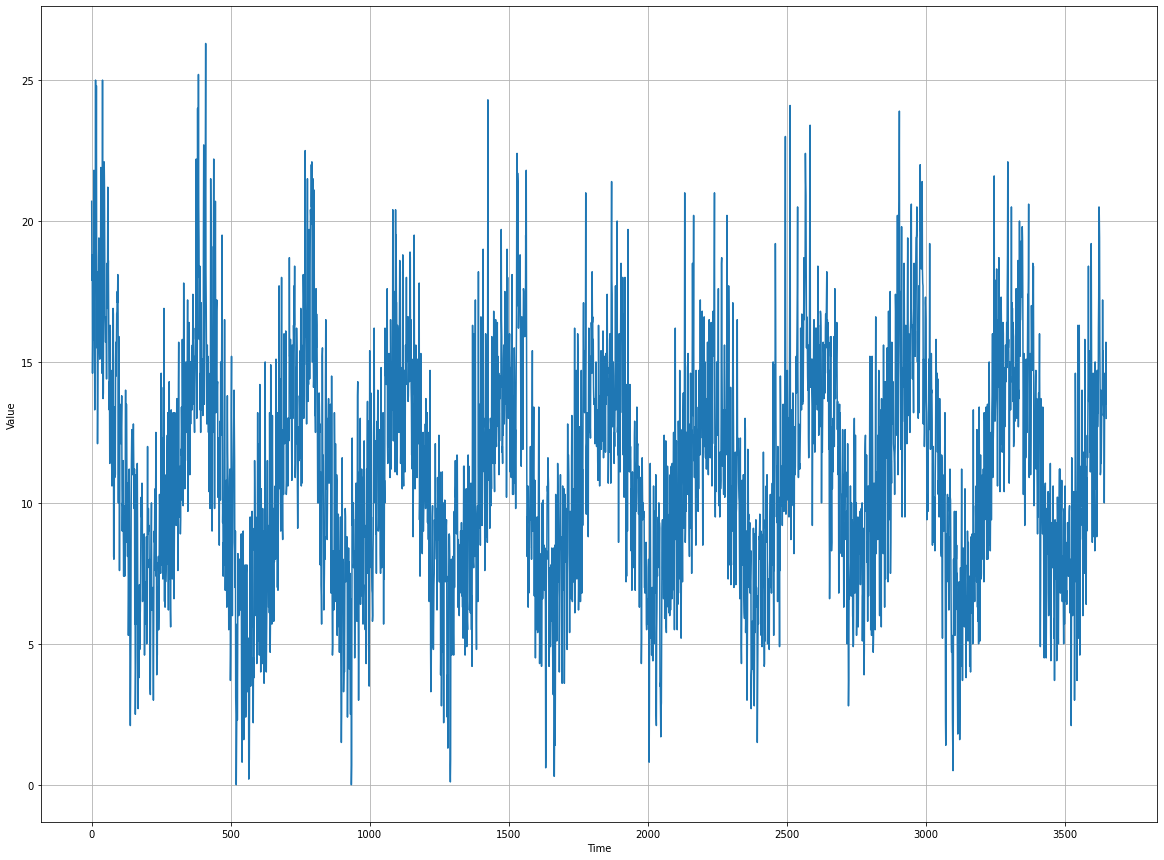

In [5]:
import csv
time_step = []
temps = []

with open('/tmp/daily-min-temperatures.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')   # READ TEMPERATURES INTO TEMPS. HAVE TIME STEPS BE A SIMPLE ARRAY OF 1, 2, 3, 4 etc
  next(reader)
  ct = 0
  for sample in reader:
    temps.append(float(sample[1]))
    time_step.append(ct)
    ct+=1

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(20, 15))
plot_series(time, series)

In [6]:
min(temps), max(temps)

(0.0, 26.3)

In [7]:
split_time = 2500
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

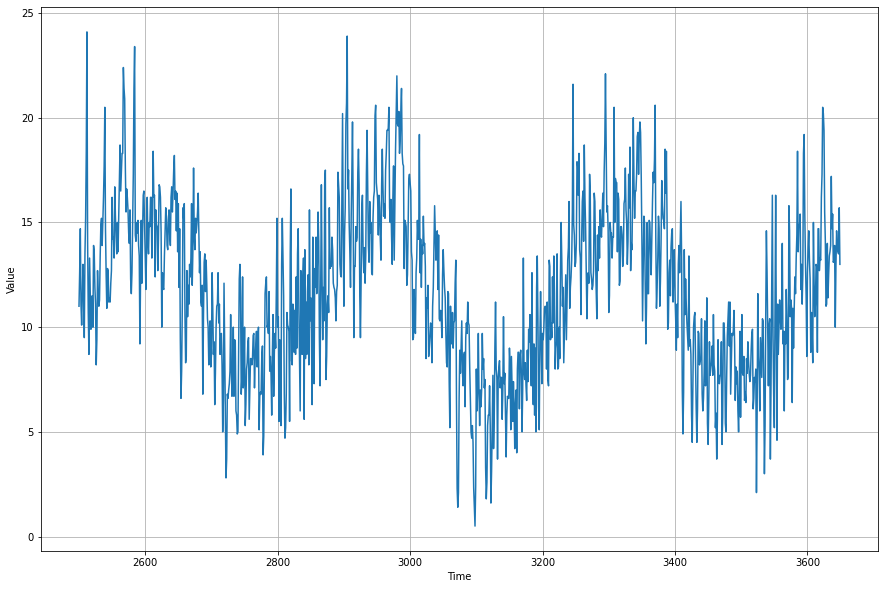

In [8]:
plt.figure(figsize=(15, 10))
plot_series(time_valid, x_valid)

In [9]:
window_size = 64
batch_size = 32
shuffle_buffer_size = 1000

In [203]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [204]:
def model_forecast(model, series, window_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size))
  ds = ds.batch(32).prefetch(1)
  forecast = model.predict(ds)
  return forecast

In [205]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 60
batch_size = 250
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)  # (total train samples,)

<PrefetchDataset shapes: ((None, None, 1), (None, 1)), types: (tf.float64, tf.float64)>
(2500,)


In [206]:
for i in train_set:
  print(i[0].shape, i[1].shape)  # (batch_size, time_steps, 1), (batch_size, 1)
  break

(250, 60, 1) (250, 1)


In [207]:
model = tf.keras.models.Sequential([
                                    tf.keras.layers.Conv1D(30, 5, padding='causal', activation='relu', input_shape=[None,1]),
                                    tf.keras.layers.Conv1D(60, 5, padding='causal', activation='relu'),
                                    tf.keras.layers.LSTM(30, return_sequences=True),
                                    # tf.keras.layers.LSTM(30, return_sequences=True),
                                    tf.keras.layers.LSTM(10),
                                    tf.keras.layers.Dense(30, activation='relu'),
                                    # tf.keras.layers.Dense(10, activation='relu'),
                                    tf.keras.layers.Dense(1),
                                    tf.keras.layers.Lambda(lambda x: x*100)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
10/10 [==============================] - 3s 20ms/step - loss: 14.9275 - mae: 15.4275
Epoch 2/100
10/10 [==============================] - 0s 32ms/step - loss: 14.9316 - mae: 15.4316
Epoch 3/100
10/10 [==============================] - 0s 29ms/step - loss: 14.8474 - mae: 15.3474
Epoch 4/100
10/10 [==============================] - 0s 27ms/step - loss: 14.8649 - mae: 15.3649
Epoch 5/100
10/10 [==============================] - 0s 32ms/step - loss: 14.7505 - mae: 15.2505
Epoch 6/100
10/10 [==============================] - 0s 32ms/step - loss: 14.8560 - mae: 15.3560
Epoch 7/100
10/10 [==============================] - 0s 33ms/step - loss: 14.6336 - mae: 15.1336
Epoch 8/100
10/10 [==============================] - 0s 29ms/step - loss: 14.5938 - mae: 15.0938
Epoch 9/100
10/10 [==============================] - 0s 31ms/step - loss: 14.6426 - mae: 15.1426
Epoch 10/100
10/10 [==============================] - 0s 25ms/step - loss: 14.3348 - mae: 14.8348
Epoch 11/100
10/10 [=========

(1e-08, 0.001, 0.0, 5.0)

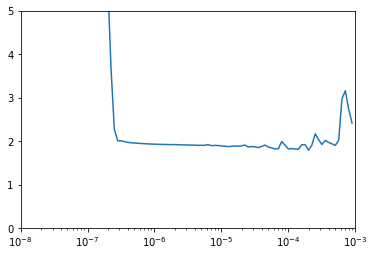

In [210]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 5])

In [209]:
cb = tf.keras.callbacks.ModelCheckpoint('./best_sunspots.h5', monitor='mae', save_best_only=True)

In [211]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
model = tf.keras.models.Sequential([
                                    tf.keras.layers.Conv1D(30, 5, padding='causal', activation='relu', input_shape=[None,1]),
                                    tf.keras.layers.Conv1D(60, 5, padding='causal', activation='relu'),
                                    tf.keras.layers.LSTM(30, return_sequences=True),
                                    # tf.keras.layers.LSTM(30, return_sequences=True),
                                    tf.keras.layers.LSTM(10),
                                    tf.keras.layers.Dense(30, activation='relu'),
                                    # tf.keras.layers.Dense(10, activation='relu'),
                                    tf.keras.layers.Dense(1),
                                    tf.keras.layers.Lambda(lambda x: x*100)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500, callbacks=[cb])
                                    
# EXPECTED OUTPUT SHOULD SEE AN MAE OF ~2 WITHIN ABOUT 30 EPOCHS

Epoch 1/500
10/10 [==============================] - 3s 21ms/step - loss: 12.2209 - mae: 12.7174
Epoch 2/500
10/10 [==============================] - 0s 29ms/step - loss: 4.5285 - mae: 5.0144
Epoch 3/500
10/10 [==============================] - 0s 28ms/step - loss: 2.9589 - mae: 3.4256
Epoch 4/500
10/10 [==============================] - 0s 25ms/step - loss: 2.5269 - mae: 2.9873
Epoch 5/500
10/10 [==============================] - 0s 32ms/step - loss: 2.4110 - mae: 2.8694
Epoch 6/500
10/10 [==============================] - 0s 24ms/step - loss: 2.3037 - mae: 2.7612
Epoch 7/500
10/10 [==============================] - 0s 26ms/step - loss: 2.2300 - mae: 2.6886
Epoch 8/500
10/10 [==============================] - 0s 36ms/step - loss: 2.2077 - mae: 2.6675
Epoch 9/500
10/10 [==============================] - 0s 31ms/step - loss: 2.1280 - mae: 2.5810
Epoch 10/500
10/10 [==============================] - 0s 36ms/step - loss: 2.0643 - mae: 2.5183
Epoch 11/500
10/10 [===========================

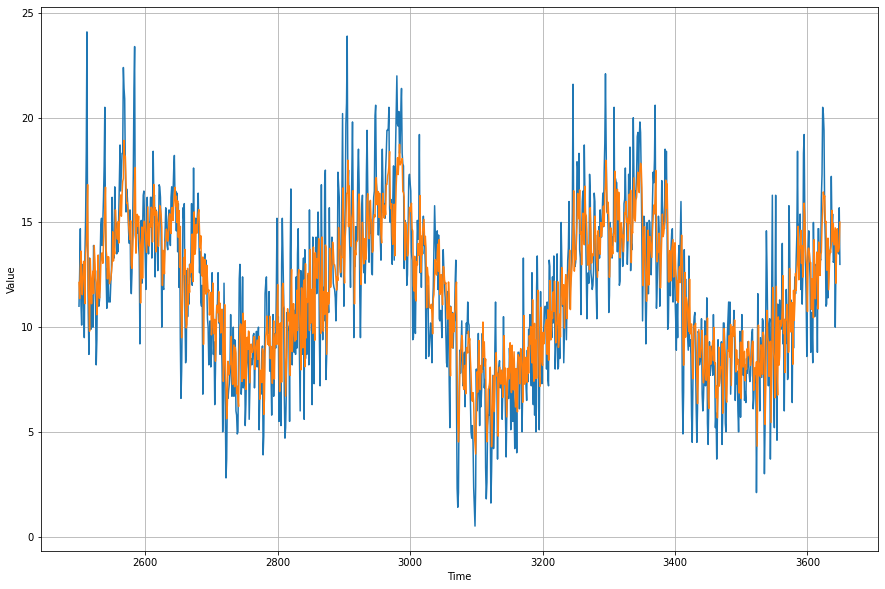

In [212]:
plt.figure(figsize=(15, 10))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

# EXPECTED OUTPUT. PLOT SHOULD SHOW PROJECTIONS FOLLOWING ORIGINAL DATA CLOSELY

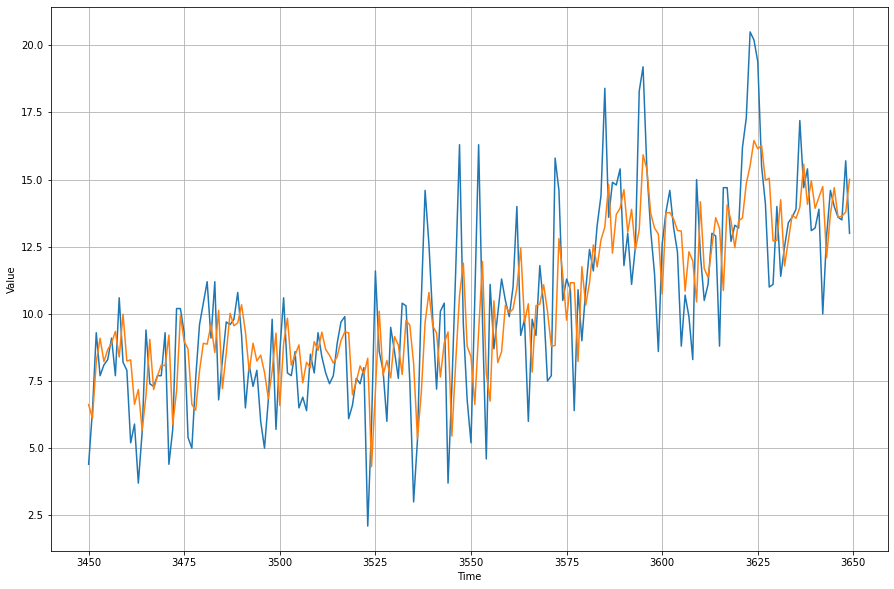

In [213]:
plt.figure(figsize=(15, 10))
plot_series(time_valid[-200:], x_valid[-200:])
plot_series(time_valid[-200:], rnn_forecast[-200:])

In [220]:
best_model = tf.keras.models.load_model('./best_sunspots.h5')

In [221]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)

In [215]:
# rnn_forecast.shape

In [222]:
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1]

In [223]:
# rnn_forecast.shape

In [224]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

# EXPECTED OUTPUT MAE < 2 -- author GOT 1.789626 (should beat this)

1.917

<Figure size 432x288 with 0 Axes>

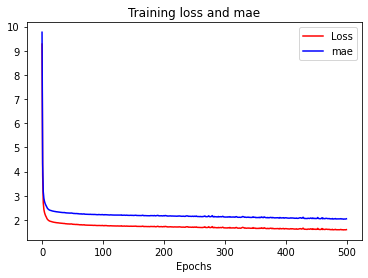

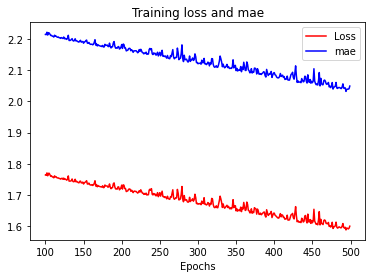

<Figure size 432x288 with 0 Axes>

In [219]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']
mae=history.history['mae']
epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, mae, 'b')
plt.title('Training loss and mae')
plt.xlabel("Epochs")
# plt.ylabel("Loss")
plt.legend(["Loss", "mae"])

plt.figure()



zoomed_loss = loss[100:]
zoomed_mae = mae[100:]
zoomed_epochs = range(100,500)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.plot(zoomed_epochs, zoomed_mae, 'b')
plt.title('Training loss and mae')
plt.xlabel("Epochs")
# plt.ylabel("Loss")
plt.legend(["Loss", "mae"])

plt.figure()

another 500 epochs

In [230]:
history = model.fit(train_set,epochs=500, callbacks=[cb])      ## triain for 500 more as loss and mae is goin down 

Epoch 1/500
10/10 [==============================] - 0s 26ms/step - loss: 1.5246 - mae: 1.9682
Epoch 2/500
10/10 [==============================] - 0s 27ms/step - loss: 1.5207 - mae: 1.9621
Epoch 3/500
10/10 [==============================] - 0s 26ms/step - loss: 1.5326 - mae: 1.9756
Epoch 4/500
10/10 [==============================] - 0s 29ms/step - loss: 1.5261 - mae: 1.9696
Epoch 5/500
10/10 [==============================] - 0s 27ms/step - loss: 1.5295 - mae: 1.9731
Epoch 6/500
10/10 [==============================] - 0s 28ms/step - loss: 1.5655 - mae: 2.0099
Epoch 7/500
10/10 [==============================] - 0s 37ms/step - loss: 1.5588 - mae: 2.0024
Epoch 8/500
10/10 [==============================] - 0s 28ms/step - loss: 1.5222 - mae: 1.9648
Epoch 9/500
10/10 [==============================] - 0s 25ms/step - loss: 1.5274 - mae: 1.9687
Epoch 10/500
10/10 [==============================] - 0s 30ms/step - loss: 1.5301 - mae: 1.9718
Epoch 11/500
10/10 [=============================

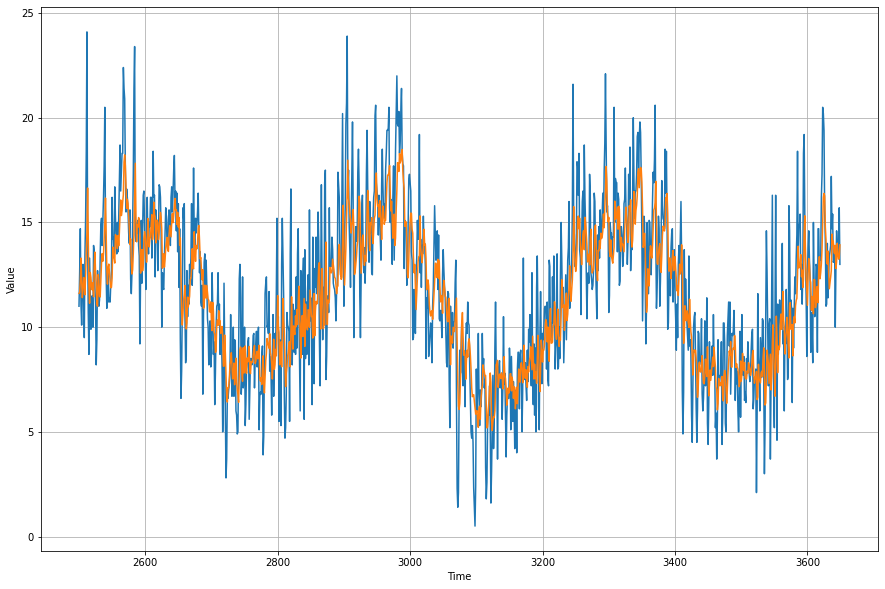

In [231]:
plt.figure(figsize=(15, 10))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

# EXPECTED OUTPUT. PLOT SHOULD SHOW PROJECTIONS FOLLOWING ORIGINAL DATA CLOSELY

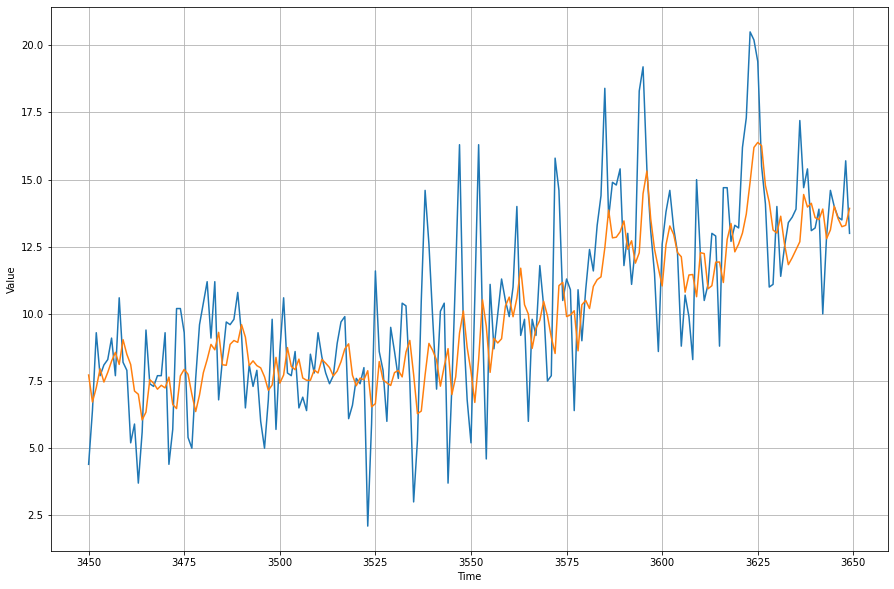

In [232]:
plt.figure(figsize=(15, 10))
plot_series(time_valid[-200:], x_valid[-200:])
plot_series(time_valid[-200:], rnn_forecast[-200:])

In [237]:
best_model = tf.keras.models.load_model('./best_sunspots.h5')

In [241]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)

In [242]:
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1]

In [243]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

# EXPECTED OUTPUT MAE < 2 -- author GOT 1.789626 (should beat this)

1.784728

ohh boy! That's close

<Figure size 432x288 with 0 Axes>

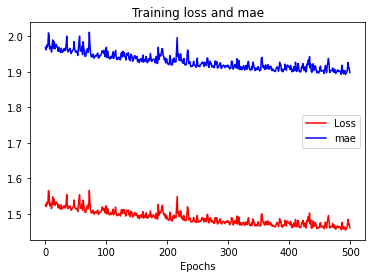

<Figure size 432x288 with 0 Axes>

In [236]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']
mae=history.history['mae']
epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, mae, 'b')
plt.title('Training loss and mae')
plt.xlabel("Epochs")
# plt.ylabel("Loss")
plt.legend(["Loss", "mae"])

plt.figure()

lets train for 150 more just to check

In [244]:
history = model.fit(train_set,epochs=150, callbacks=[cb])

Epoch 1/150
10/10 [==============================] - 0s 26ms/step - loss: 1.4597 - mae: 1.8991
Epoch 2/150
10/10 [==============================] - 0s 27ms/step - loss: 1.4588 - mae: 1.8968
Epoch 3/150
10/10 [==============================] - 0s 23ms/step - loss: 1.4573 - mae: 1.8940
Epoch 4/150
10/10 [==============================] - 0s 31ms/step - loss: 1.4595 - mae: 1.8984
Epoch 5/150
10/10 [==============================] - 0s 25ms/step - loss: 1.4640 - mae: 1.9038
Epoch 6/150
10/10 [==============================] - 0s 25ms/step - loss: 1.4585 - mae: 1.8971
Epoch 7/150
10/10 [==============================] - 0s 24ms/step - loss: 1.4540 - mae: 1.8923
Epoch 8/150
10/10 [==============================] - 0s 26ms/step - loss: 1.4602 - mae: 1.8985
Epoch 9/150
10/10 [==============================] - 0s 26ms/step - loss: 1.4594 - mae: 1.8984
Epoch 10/150
10/10 [==============================] - 0s 31ms/step - loss: 1.4562 - mae: 1.8948
Epoch 11/150
10/10 [=============================

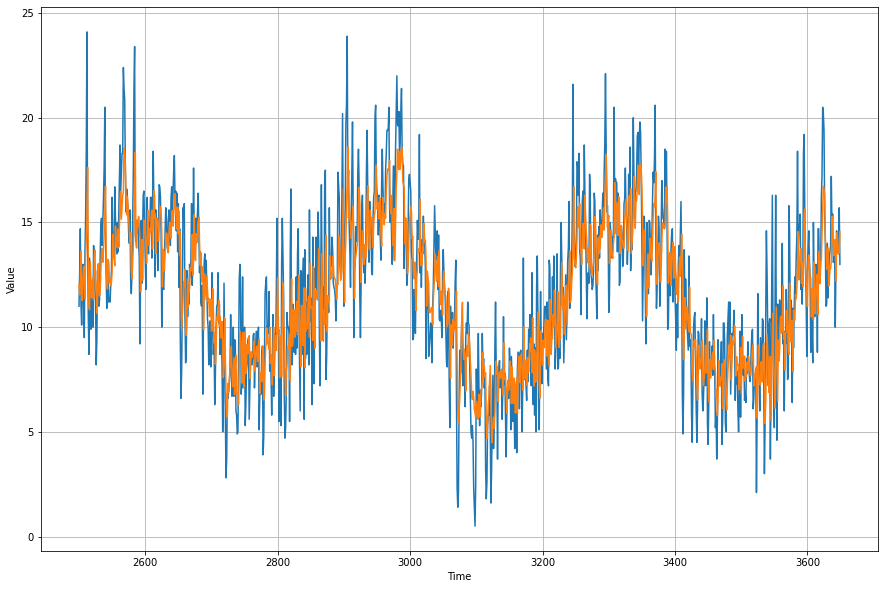

In [245]:
plt.figure(figsize=(15, 10))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

# EXPECTED OUTPUT. PLOT SHOULD SHOW PROJECTIONS FOLLOWING ORIGINAL DATA CLOSELY

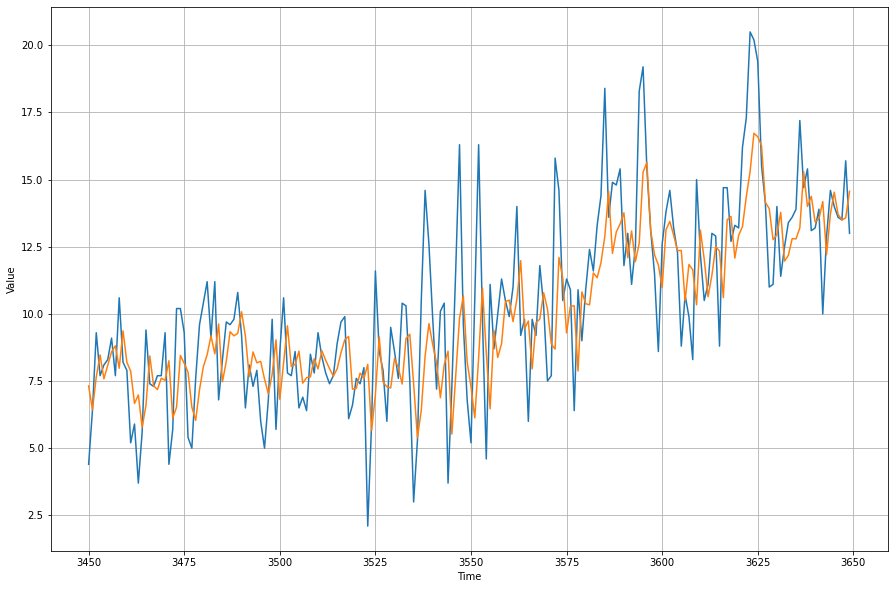

In [246]:
plt.figure(figsize=(15, 10))
plot_series(time_valid[-200:], x_valid[-200:])
plot_series(time_valid[-200:], rnn_forecast[-200:])

In [251]:
best_model = tf.keras.models.load_model('./best_sunspots.h5')

In [255]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)

In [256]:
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1]

In [257]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

# EXPECTED OUTPUT MAE < 2 -- author GOT 1.789626 (should beat this)

1.7799163

fine. That's enough to satisfy my ego ;-p

<Figure size 432x288 with 0 Axes>

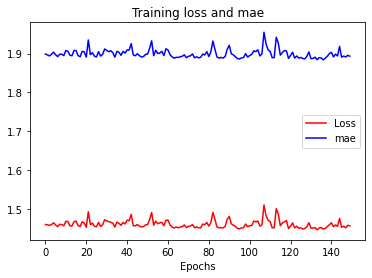

<Figure size 432x288 with 0 Axes>

In [250]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']
mae=history.history['mae']
epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, mae, 'b')
plt.title('Training loss and mae')
plt.xlabel("Epochs")
# plt.ylabel("Loss")
plt.legend(["Loss", "mae"])

plt.figure()